In [17]:
import YouTube_Data_Story as ds
import YouTube_Data_Wrangling as dw
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

import matplotlib as mpl

from scipy import stats
from matplotlib.patches import Patch

import warnings

import matplotlib.ticker as ticker
from scipy.stats import chi2_contingency
from scipy.stats import chi2

#warnings.filterwarnings('ignore')

In [2]:
#DataFrames
df_usa=dw.combined_usa_mx_df[dw.combined_usa_mx_df.country=='USA']
df_mx=dw.combined_usa_mx_df[dw.combined_usa_mx_df.country=='Mexico']

#DF Views
df_usa_views=df_usa['views']
df_mx_views=df_mx['views']

#DF Childish Gambino Video Analysis
temp_usa=dw.usa_df
high_views_usa_df=temp_usa[temp_usa.video_id=='VYOjWnS4cMY'] #video_id of "childish gambino - This is Ameica"
high_views_usa_df_clean=high_views_usa_df[['trending_date', 'views']]
high_views_usa_df_clean.reset_index(inplace=True, drop=True)
childish_gambino_df=high_views_usa_df_clean
array=np.arange(1,26)
childish_gambino_df['days']=array


#Shows in USA
shows_usa_df=dw.combined_usa_mx_df.loc[dw.combined_usa_mx_df.category_name=='Shows']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [3]:
#FUNCTIONS:

def ecdf(data):
    x=np.sort(data)
    y=np.arange(1,len(x)+1)/len(x)
    _=plt.plot(x,y,marker='.',linestyle='none') 

def vertical_line(axes,number,label, color, text_place):
    axes.axvline(number, color=color, linestyle=':', label=label, lw=2.5)
    axes.text(number,text_place,'{:,.2f}M' .format(number/1000000),rotation=90, fontsize=15, color='k', weight='bold')
    #axes.legend(loc=0) 

def draw_bs_reps(data,func,size=1):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_samples=np.random.choice(data, len(data))
        bs_replicates[i]=func(bs_samples)
    return bs_replicates

def histo(axes,df,title,x_label,y_label,xlim,bins=20, density=False, histtype='bar'):
    df.plot.hist(ax=axes,bins=bins,density=density)
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    axes.set_title(title)
    axes.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000) + 'M'))
    if xlim != 0:
        axes.set_xlim([0, xlim])
                       #20 million 
    plt.tight_layout()
        
def samplestats(df,percent):
    mean=np.mean(df)
    std=np.std(df,ddof=1)
    median=np.median(df)
    percentile=np.percentile(df,percent)
    return mean,std,median,percentile

###  Scenario 1:
For YouTube (Client) to consider investing properly in people, infrastructure etc, they need to know audience engagement with the videos in both countries. 
For this they need to know the views distribution and a 95% confidence interval around the population mean.
1. Considering df_usa_views to be a sample, the goal is to infer population statistics for all the video views across all categories in the USA.
2. Considering df_usa_views to be a sample, the goal is to infer population statistics for all the video views across all categories in the USA.


#### Scenario 1 - Sample Statiscs of  Views in USA and Mexico:
.Finding sample statistics of the "views" in the USA/MX. Sample is the data provided in df_usa_views and df_mx_views


________________________________________________
USA SAMPLE STATISTICS - VIEWS
________________________________________________
.95% of the views are under: 8.89M
.Other statistics of the views in the USA:
.Sample Mean= 2.33M
.Sample Standard Error = 7.26M
.Sample Median= 0.67M
.The PEAK of the distribution is closer to it's median 0.67M, rather than mean 2.33M
...This is expected behavior from a left skewed distribution
________________________________________________
Mexico SAMPLE STATISTICS - VIEWS
________________________________________________
.95% of the views are under: 1.19M
.Other statistics of the views in the Mexico:
.Sample Mean= 0.33M
.Sample Standard Error = 1.45M
.Sample Median= 0.06M


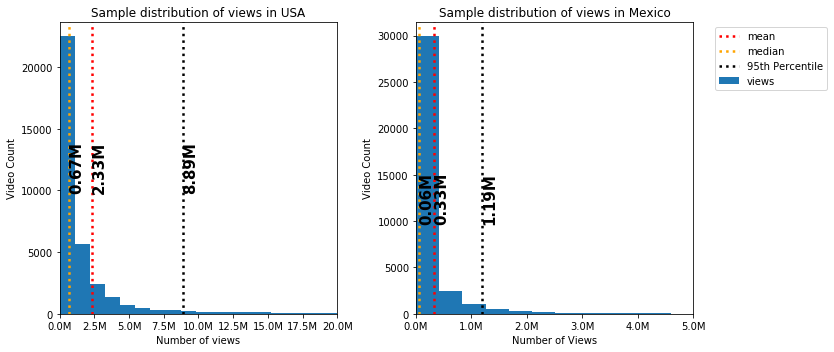

In [4]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))

#1. Sample stats of USA(df_usa_views)
mean_views_usa,std_views_usa,median_views_usa,percentile_views_usa= samplestats(df_usa_views,95)

# 2. Plotting hist distribution of USA(sample df_usa_views)

#Almost all of the videos in USA got views under 20 million mark therefore I set the xlim(0, 20Million)

histo(axes[0],df_usa_views,title='Sample distribution of views in USA', x_label='Number of views',y_label='Video Count',xlim=20000000,bins=200)
#Plotting Mean vertical line
vertical_line(axes[0],mean_views_usa, 'mean', 'r', 10000)
#Plotting Median vertical line
vertical_line(axes[0],median_views_usa, 'median', 'orange', 10000)
#Plotting 95th percentile
vertical_line(axes[0],percentile_views_usa, '95th Percentile', 'k',10000)
axes[0].legend().remove()

#1. Sample stats of MX(df_mx_views)
mean_views_mx,std_views_mx,median_views_mx,percentile_views_mx= samplestats(df_mx_views,95)

# 2. Plotting hist distribution of MX(sample df_mx_views)

histo(axes[1],df_mx_views,title='Sample distribution of views in Mexico',x_label= 'Number of Views',y_label='Video Count',xlim=5000000,bins=150)
#Plotting Mean vertical line
vertical_line(axes[1],mean_views_mx, 'mean', 'r', 10000)
#Plotting Median vertical line
vertical_line(axes[1],median_views_mx, 'median', 'orange', 10000)
#Plotting 95th percentile
vertical_line(axes[1],percentile_views_mx, '95th Percentile', 'k',10000)
axes[1].legend(bbox_to_anchor=(1.5, 1.00))


#Commentary
print('________________________________________________')
print("USA SAMPLE STATISTICS - VIEWS")
print('________________________________________________')
print(".95% of the views are under: " + '{:,.2f}M' .format(percentile_views_usa/1000000))
print(".Other statistics of the views in the USA:")
print('.Sample Mean= {:,.2f}M'.format(mean_views_usa/1000000))
print('.Sample Standard Error = {:,.2f}M'.format(std_views_usa/1000000))
print('.Sample Median= {:,.2f}M'.format(median_views_usa/1000000))
print(".The PEAK of the distribution is closer to it's median {:,.2f}M, rather than mean {:,.2f}M".format(median_views_usa/1000000, mean_views_usa/1000000))
print("...This is expected behavior from a left skewed distribution")
print('________________________________________________')
print("Mexico SAMPLE STATISTICS - VIEWS")
print('________________________________________________')
print(".95% of the views are under: " + '{:,.2f}M' .format(percentile_views_mx/1000000))
print(".Other statistics of the views in the Mexico:")
print('.Sample Mean= {:,.2f}M'.format(mean_views_mx/1000000))
print('.Sample Standard Error = {:,.2f}M'.format(std_views_mx/1000000))
print('.Sample Median= {:,.2f}M'.format(median_views_mx/1000000))
#print(".The PEAK of the distribution is closer to it's median {:,.2f}M, rather than mean {:,.2f}M".format(median/1000000, mean/1000000))
#print("...This is expected behavior from a left skewed distribution")



#### Scenario 1 - Statistical Inference about Views in USA and Mexico:
.1.Calculating 95% CI around the USA videos views [population mean (mean views of all YouTube videos watched in USA)]

.2.Calculating 95% CI around the Mexico videos views [population mean (mean views of all YouTube videos watched in Mexico)]

Taking bootstrap inference approach here. Creating 10,000 bootstrap samples from the given usa views sample (df_usa_views) and calculating the mean of each. Repeating same process for Mexico views sample (df_mx_views)

In [5]:
np.random.seed(47)
# USA Inference Views
# Creating bootstrap samples and taking their means

df_usa_views_mean_rep=draw_bs_reps(df_usa_views, np.mean,10000)
# Finding 95% Confidence Interval around population mean. 
CI_95_usa_views_mean=np.percentile(df_usa_views_mean_rep,[2.5,97.5])
df_usa_views_mean_rep=pd.DataFrame({'BS Mean Views': df_usa_views_mean_rep})

# MX Inference Views
# Creating bootstrap samples and taking their means
df_mx_views_mean_rep=draw_bs_reps(df_mx_views, np.mean,10000)
# Finding 95% Confidence Interval around population mean. 
CI_95_mx_views_mean=np.percentile(df_mx_views_mean_rep,[2.5,97.5])
df_mx_views_mean_rep=pd.DataFrame({'BS Mean Views': df_mx_views_mean_rep})

USA:Confidence interval (95%) for population mean is [2.25M ,2.41M]
Mexico:Confidence interval (95%) for population mean is [0.31M ,0.34M]


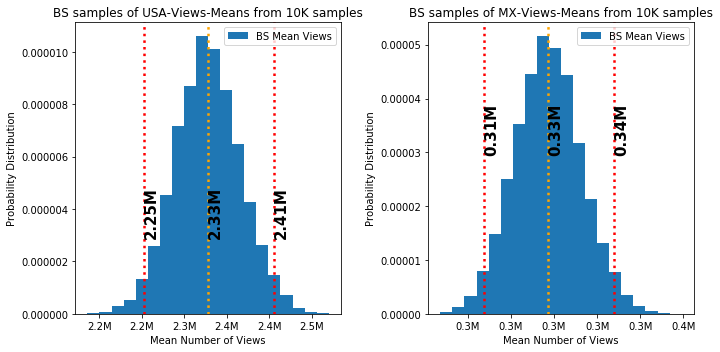

In [6]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
#USA
#Plotting the hist of the BS rep means and CI 
histo(axes[0],df_usa_views_mean_rep,"BS samples of USA-Views-Means from 10K samples","Mean Number of Views","Probability Distribution",xlim=0, bins=20, density=True, histtype='step')

#CI lines
vertical_line(axes[0],CI_95_usa_views_mean[0], 'Lower_Limit', 'r', 0.000003)
vertical_line(axes[0],CI_95_usa_views_mean[1], 'Upper_Limit', 'r', 0.000003)
#Mean line
vertical_line(axes[0],mean_views_usa, 'Sample Mean', 'orange', 0.000003)

#CI_95_usa_views_mean
print('USA:Confidence interval (95%) for population mean is [{:,.2f}M'.format(CI_95_usa_views_mean[0]/1000000) + ' ,{:,.2f}M]'.format(CI_95_usa_views_mean[1]/1000000))

############
#MX
#Plotting the hist of the BS rep means and CI 
histo(axes[1],df_mx_views_mean_rep,"BS samples of MX-Views-Means from 10K samples","Mean Number of Views","Probability Distribution",xlim=0, bins=20, density=True, histtype='step')

#CI lines
vertical_line(axes[1],CI_95_mx_views_mean[0], 'Lower_Limit', 'r', 0.00003)
vertical_line(axes[1],CI_95_mx_views_mean[1], 'Upper_Limit', 'r', 0.00003)
#Mean line
vertical_line(axes[1],mean_views_mx, 'Sample Mean', 'orange', 0.00003)

#CI_95_mx_views_mean
print('Mexico:Confidence interval (95%) for population mean is [{:,.2f}M'.format(CI_95_mx_views_mean[0]/1000000) + ' ,{:,.2f}M]'.format(CI_95_mx_views_mean[1]/1000000))




In [7]:
#Outlier in USA_Views df
a=max(df_usa['views'])/1000000
df_usa[df_usa['views']==217750076]

,trending_date,title,category_id,publish_time,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_name,country
38098,2018-05-31,Childish Gambino - This Is America (Official V...,10,2018-05-06,217750076,4934188,335462,509799,False,False,False,Music,USA


#### Analysis of Scenario 1
.<b>For USA-Views</b>: With the bootstrap inference, it can be concluded that there is a 95% chance that the population mean (all videos views) lie between 2.25M and 2.41M.

.<b>For Mx-Views</b>: With the bootstrap inference, it can be concluded that there is 95% chance that the population mean (all videos views) lie between 0.31M and 0.34M 

From previous histogram of views in USA it can be seen that the mean views of the sample was not close to the datapoint where majority of the data lay. This is because of the outlier (max views of one of the Music video 'Childish Gambino-This is America" has 217M) skewed the data. This anamoly is not really an anamoly since every year there will be video/videos more popular than others. Therefore by using BS I was still able to see an average number of views in USA and MX without outlier's influence on the statistic.




##############################################################################################################################

### Scenario 2
. Does the number of videos in each category depends upon country it is viewed in? or country has no effect on the video categories and the number of videos in each category? 

#H0: We will assume that country and the category variables are independent (TRUE)
#H1: The country and the category variables are not independent

Note: Chi2 Test and it's results' interpretation and how is it used with Python was learned from https://machinelearningmastery.com/chi-squared-test-for-machine-learning/


In [8]:
#The Pearson’s chi-squared statistical hypothesis tests independence between two categorical variables. (country/category_name)
#Create a contingency table for applying Chi Squared Test. 

#Creating Contingency Table:
chi_sq_table_views=pd.pivot_table(dw.combined_usa_mx_df,index=["country"], columns=['category_name'], values=['views'], aggfunc='count', fill_value=0)

#chi2_contingency(table) from scipy.stats, calculates, stat, p-value, dof(degree of freedom) and expected values of the given contingency "table"
stat, p, dof, expected = chi2_contingency(chi_sq_table_views)

#Test static interpretation with probability = 0.95
prob = 0.95
critical = chi2.ppf(prob, dof)
print('Probability=%.2f, Critical=%.2f, Stat=%.2f' % (prob, critical, stat))

if abs(stat) >= critical:
    print('Stat is greater than critical value therefore variables are Dependent (reject H0)')
else:
    print('Stat is less than critical value therefore variables are Independent (do not reject H0)')
    
# Interpreting p-value using alpha 

alpha = 1.0 - prob
print('Significance=%.2f, p=%.2f' % (alpha, p))

if p <= alpha:
    print('P-value is less than alpha (significance level) therefore variables are Dependent (reject H0)')
else:
    print('P-value is greater than alpha (significance level) therefore variables are Independent (do not reject H0)')

Probability=0.95, Critical=25.00, Stat=7532.27
Stat is greater than critical value therefore variables are Dependent (reject H0)
Significance=0.05, p=0.00
P-value is less than alpha (significance level) therefore variables are Dependent (reject H0)


#### Analysis of Scenario2
. Since results show that stat returned from the chi2-test is greater than the critical value, the two variables are dependent

. Since results show that the p-value returned from the chi2- test is less than alpha, the two variables are dependent

##############################################################################################################################

### Scenario 3
#### Most popular video trend in USA: How does expected value of the views changes from day 1 to day it is most popular? 

.Part 1: Expected Values of the views per day
..The most popular video in the usa on YouTube is in Music Category titled "Childish Gambino - This is America". It was introduced on May 8th 2018 and collected views in abundance till it reached 225M on June 2nd 2018. When did the video actually take off? What is expected value of views from the day it started to the last day the data was collected for this YouTube data set

.Part 2: Expected Value of the Differences in Views (How many more or less views did the video receive everyday compared to previous day)
 


#### Scenario 3 - PART 1: Expected Values of the views of most the most viewed video 
.Using Baysian Inference methods, an analysis is presented on the expected number of views collected between 2 periods (there could be more but for this analysis only two are presented)

The mean of the views collected for this video is 150.34M


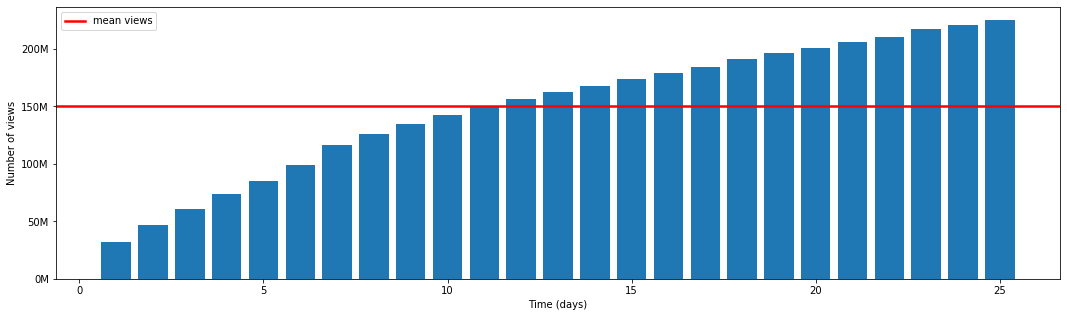

In [9]:
childish_gambino_gp_df=childish_gambino_df.drop(['trending_date'], axis=1)
f, ax = plt.subplots(figsize=(18,5))

_=plt.bar(childish_gambino_gp_df.days, childish_gambino_gp_df.views)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M'))

_=plt.xlabel("Time (days)")
_=plt.ylabel("Number of views")

mean_childish=np.mean(childish_gambino_gp_df.views)
childish_array=np.array(childish_gambino_gp_df.views)


print('The mean of the views collected for this video is {:,.2f}M'.format(mean_childish/1000000))
ax.axhline(mean_childish, color='r', label='mean views', lw=2.5)
ax.legend(loc='upper left')
alpha=1.0/mean_childish


##### Observations from bar plot of Childish Gambino's - This is America Video Views
1. By looking at "Childish Gambinos - This is America" video views bar plot , it can be seen that the mean of several periods is not same number of 150M. Lets say a popular video which has same genre and vibe of Childish Gambino and producers want to see when can they expect to hit most views or atleast see a momentum? 

2. From Baysian methods for the hackers book, we can start to model this by defining a Poisson random variable(RV) as it can models a count data therefore views count on day i ~ Poi(lambda)

3. Lambda is unknown

4. It can be observed from views count above that rate increases as the days go up.

5. However the rate is different for <i>atleast</i> 2 different periods of times (days)

6. lamda_1 and lambda_2 are defined as those two periods. 
7. And tau_1 is defined as a day when the change of rate occurs. There are several possibilities but keeping it as Uniform Distribution between 0 and 25 [tau_1 ~ DiscreteUniform(1,25)]

8. All the a prior distributions are defined below and we will find posterior distributions of Lambda_1, Lambda_2 and tau_1

In [10]:
n_count_data=len(childish_gambino_gp_df)

with pm.Model() as model:
    alpha=1.0/mean_childish
    lambda_1=pm.Exponential("lambda_1", alpha)
    lambda_2=pm.Exponential("lambda_2", alpha)
   
    
    tau_1=pm.DiscreteUniform("tau_1", lower=1, upper=n_count_data)
  
with model:
    idx=np.arange(n_count_data)
    lambda_=pm.math.switch(tau_1 >=idx, lambda_1, lambda_2)
    observations= pm.Poisson("obs", lambda_, observed=childish_array)
    
with model:
    step = pm.Metropolis()
    trace = pm.sample(20000, tune=5000,step=step)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau_1]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains, 0 divergences: 100%|█████████████████████████████████████| 50000/50000 [00:24<00:00, 2029.55draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


(0, 1.0)

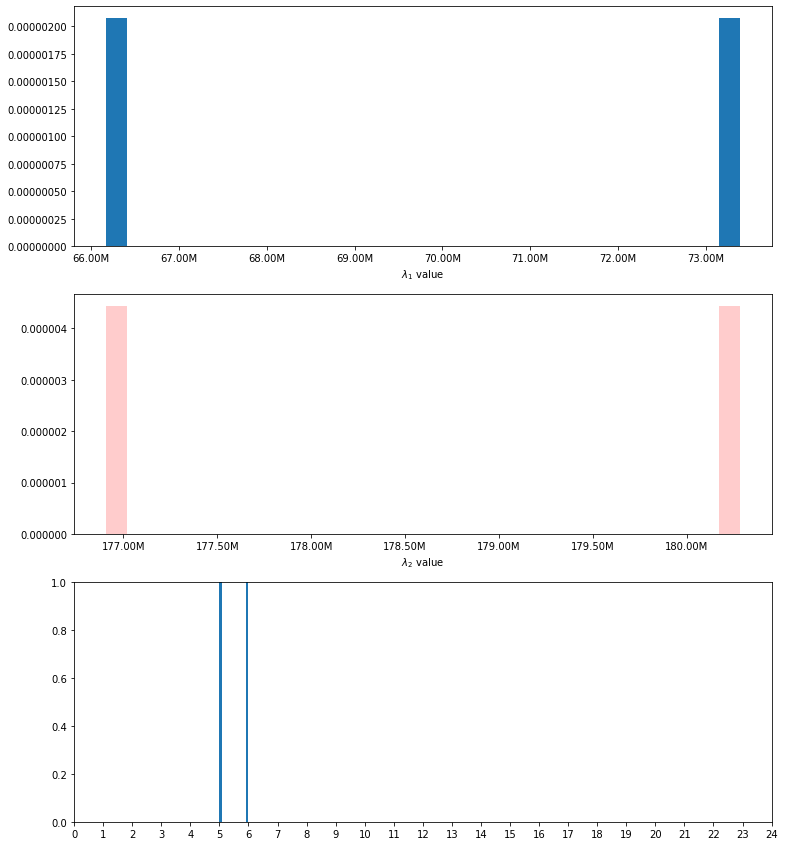

In [11]:
%matplotlib inline
from IPython.core.pylabtools import figsize

lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']

tau_1_samples = trace['tau_1']


figsize(12.5,15)

ax=plt.subplot(311)
plt.hist(lambda_1_samples, bins=30, density=True)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000000) + 'M'))
plt.xlabel("$\lambda_1$ value")


ax=plt.subplot(312)
plt.hist(lambda_2_samples, bins=30, density=True, color='r', alpha=0.2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000000) + 'M'))
plt.xlabel("$\lambda_2$ value")


ax=plt.subplot(313)
counts, bins = np.histogram(tau_1_samples)
plt.hist(bins[:-1], bins, weights=counts)
plt.xticks(np.arange(n_count_data))
plt.ylim([0, 1.0])
    

#### Analysis of posterior distributions of lambda_1, lambda_2 and tau_1
.Lambda_1 and Lambda_2 distributions are not exponential as we started with. The MCMC "engine" plugs in those two variables along with tau_1 and produce a posterior distributions that are more appropriate to the given views data of the video. 

.Tau_1 distribution started with Uniform distribution and the MCMC provided that the change likely happened between 5th and 6th day of the release of the video

#### Below is graph that shows expected value of the views of "Childish Gambino's - This is America" on the intervals predicted by tau_1 variable.

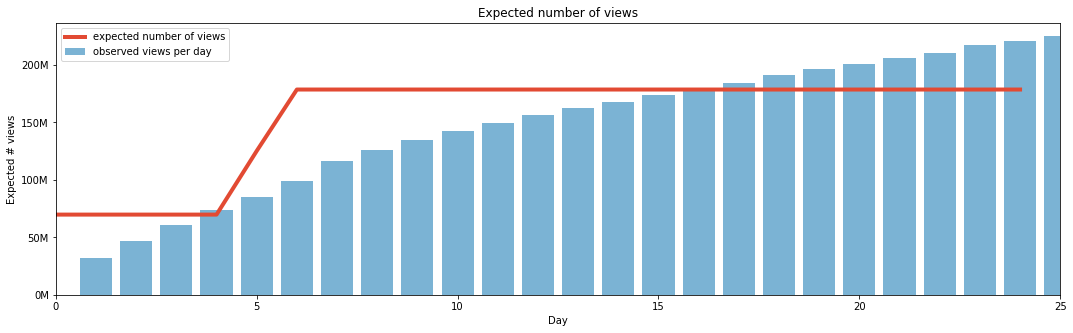

In [12]:
# This code is taken and modified from the book "Baysian Methods for Hackers"
#tau_1_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution

N = tau_1_samples.shape[0]

expected_views_per_day = np.zeros(n_count_data)

for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    
    ix = day < tau_1_samples
   
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # The "Number of Views" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "Number of Views".
    
    expected_views_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N

f, ax = plt.subplots(figsize=(18,5))
plt.plot(range(n_count_data), expected_views_per_day, lw=4, color="#E24A33",
         label="expected number of views")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # views")
plt.title("Expected number of views")
#plt.ylim(0, 60)
plt.bar(childish_gambino_gp_df.days, childish_gambino_gp_df.views, color="#348ABD", alpha=0.65,
        label="observed views per day")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M'))

plt.legend(loc="upper left")

#### Analysis of the expected views graph on the intervals:
.Clearly the change in views happend between day 5 and 6. Expected value of views went from 75M to 180M views as shown by the posterior distributions

##### Scenario 3 - Part 2: Expected Value of the  Differences in Views (How many more or less views did the video receive everyday compared to previous day)

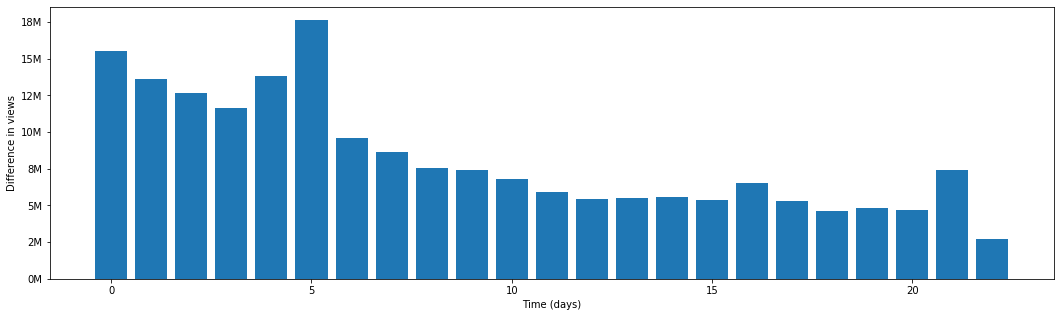

In [13]:
childish_diff=[]
for i in range(len(childish_array)-2):
        
        temp= childish_array[i+1] - childish_array[i]
      
        childish_diff.append(temp)

childish_diff_array=np.array(childish_diff)

f, ax = plt.subplots(figsize=(18,5))
_=plt.bar(np.arange(23), childish_diff_array)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M'))
_=plt.xlabel("Time (days)")
_=plt.ylabel("Difference in views")

##### Analysis of the Difference in Views bar graph
.The most difference in views occurred on day 5 which was predicted by our model previously i.e it chose day 5/6 accurately to predict the one switch point. It can be seen that there are more than 1 switchpoints but since the previous model only had one (tau_1) the MCMC engine chose day5/6 as the most "viable" candidate. 

.Below a similar model for difference in views is produced as was done for views per day for "Childish Gambino's" video. two switchpoints are chosen by me however there clearly are more than two here. To keep complexity in control, two switchpoint are OK! Two switchpoints mean three different rates for three periods (lambda_1, lambda_2 and lambda_3) 

In [14]:
n_count_data1=len(childish_diff_array)
mean_diff_childish=np.mean(childish_diff_array)

with pm.Model() as model1:
    alpha1=1.0/mean_diff_childish
    lambda_1_a=pm.Exponential("lambda_1_a", alpha1)
    lambda_2_a=pm.Exponential("lambda_2_a", alpha1)
    lambda_3_a=pm.Exponential("lambda_3_a", alpha1)
   
    
    tau_1_a=pm.DiscreteUniform("tau_1_a", lower=1, upper=n_count_data)
    tau_2_a=pm.DiscreteUniform("tau_2_a", lower=tau_1_a, upper=n_count_data)
    
with model1:
    idx=np.arange(n_count_data1)
    
    lambda_ = pm.math.switch(tau_2_a >= idx, pm.math.switch(tau_1_a >= idx, lambda_1_a, lambda_2_a), lambda_3_a)
    observations= pm.Poisson("obs", lambda_, observed=childish_diff_array)
    
with model1:
    step = pm.Metropolis()
    trace = pm.sample(20000, tune=5000,step=step)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau_2_a]
>Metropolis: [tau_1_a]
>Metropolis: [lambda_3_a]
>Metropolis: [lambda_2_a]
>Metropolis: [lambda_1_a]
Sampling 2 chains, 0 divergences: 100%|█████████████████████████████████████| 50000/50000 [00:29<00:00, 1673.55draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


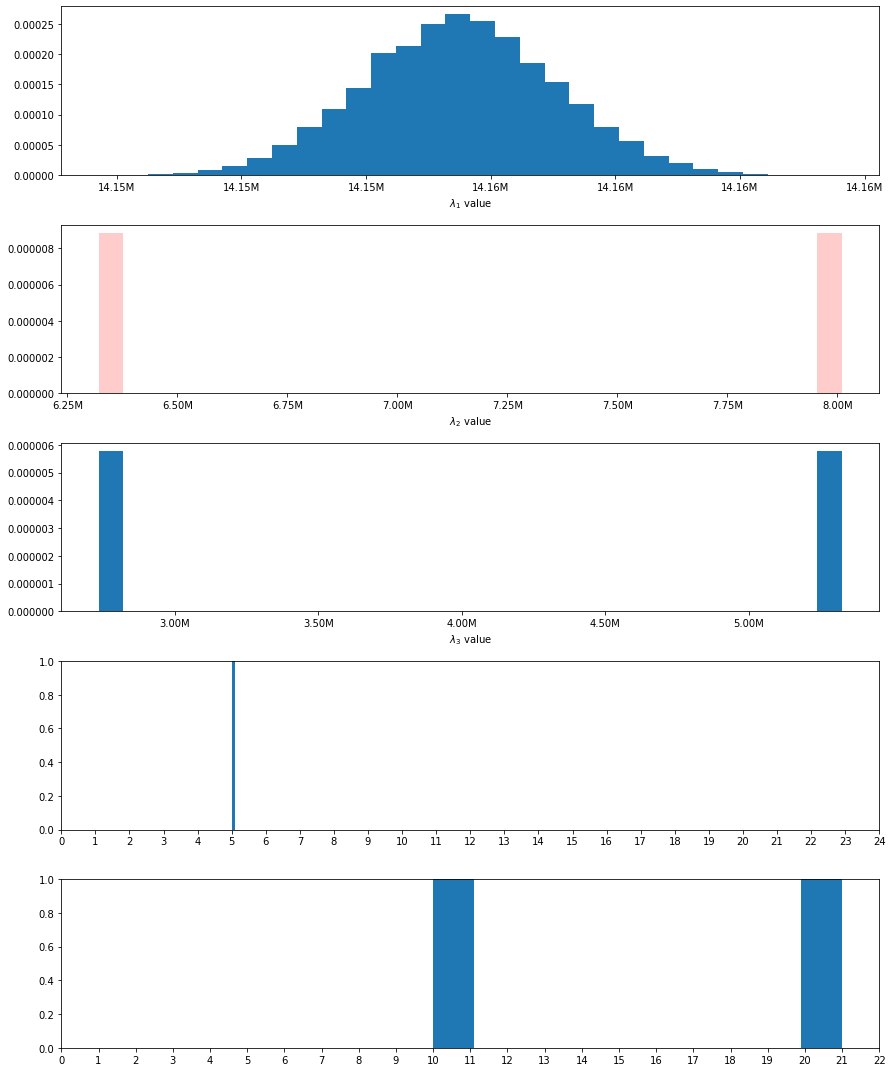

In [15]:
%matplotlib inline
from IPython.core.pylabtools import figsize

lambda_1_a_samples = trace['lambda_1_a']
lambda_2_a_samples = trace['lambda_2_a']
lambda_3_a_samples = trace['lambda_3_a']

tau_1_a_samples = trace['tau_1_a']
tau_2_a_samples = trace['tau_2_a']

figsize(12.5,15)

ax=plt.subplot(511)
plt.hist(lambda_1_a_samples, bins=30, density=True)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000000) + 'M'))
plt.xlabel("$\lambda_1$ value")
#plt.xlim([12500,1200000])


ax=plt.subplot(512)
plt.hist(lambda_2_a_samples, bins=30, density=True, color='r', alpha=0.2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000000) + 'M'))
plt.xlabel("$\lambda_2$ value")
#plt.xlim([12500,1200000])


ax=plt.subplot(513)
plt.hist(lambda_3_a_samples, bins=30, density=True)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000000) + 'M'))
plt.xlabel("$\lambda_3$ value")
#plt.xlim([15000,1200000])


ax=plt.subplot(514)
counts, bins = np.histogram(tau_1_a_samples)
plt.hist(bins[:-1], bins, weights=counts)
plt.xticks(np.arange(n_count_data))
plt.ylim([0, 1.0])

plt.subplot(515)
counts1, bins1 = np.histogram(tau_2_a_samples)
plt.hist(bins1[:-1], bins1, weights=counts1)
plt.xticks(np.arange(n_count_data1))
plt.ylim([0, 1.0])

plt.tight_layout()

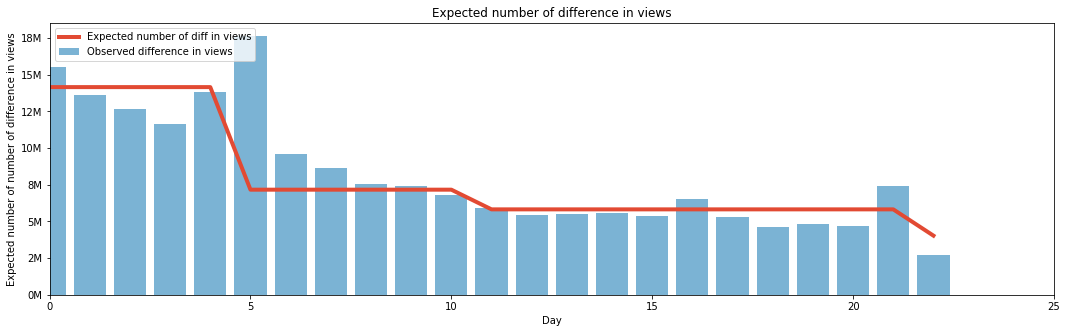

In [16]:
N1 = tau_1_a_samples.shape[0]

n_count_data1=len(childish_diff_array)

expected_diff_views_per_day = np.zeros(n_count_data1)

for day in range(0, int(np.mean(tau_1_a_samples))):
    ix = day <= tau_1_a_samples 
    expected_diff_views_per_day[day] = (lambda_1_a_samples[ix].sum() + lambda_2_a_samples[~ix].sum()) / N1

for day in range(int(np.mean(tau_1_a_samples)), n_count_data1):
    ix = day <= tau_2_a_samples
    expected_diff_views_per_day[day] = (lambda_2_a_samples[ix].sum() + lambda_3_a_samples[~ix].sum()) / N1



f, ax = plt.subplots(figsize=(18,5))

plt.plot(range(n_count_data1), expected_diff_views_per_day, lw=4, color="#E24A33",
         label="Expected number of diff in views")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected number of number of difference in views")
plt.title("Expected number of difference in views")

plt.bar(np.arange(n_count_data1), childish_diff_array, color="#348ABD", alpha=0.65, label= "Observed difference in views")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M'))

plt.legend(loc="upper left")

##### Analysis of Scenario 3 - Part 2
. The model predicted that there are two dips in the expected values. Around day5 and day 10. As any popular video eventually starts declining in viewership as time passes, this model gives a glimpse of when the most views can be achieved and when the decline start.

### PLEASE NOTE: DEPENDING UPON THE SAMPLES RETURNED BY THIS MODEL THE DIP IN DIFF IN VIEWS ARE EITHER 2 (AT 5 and 10) OR 3 (AT 5, 10 and 21). 
